In [454]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cupy as cp
from cupyx.scipy import ndimage
import argparse
import cv2
import pickle

In [455]:
matchedDir = "datasets/round_1/matched"
metricsDir = "datasets/round_1/rawData/metrics"
designDir = "datasets/round_1/rawData/design"
saveDir = "datasets/round_1/combined/"

In [456]:
rnd = 6

In [457]:
# matched
#matched_f = 'Design_final_processed_matched_random01/matchDF.npy'
#matched_f = 'Design_final_processed_matched_random02/matchDF.npy'
#matched_f = 'Design_final_processed_matched_random03/matchDF.npy'
#matched_f = 'Design_final_processed_matched_random04/matchDF.npy'
#matched_f = 'Design_final_processed_matched_random05/matchDF.npy'
matched_f = 'Design_final_processed_matched_random06/matchDF.npy'

In [458]:
# metrics
#final_f = 'exported_metrics_round1_random01_n4.csv'
#final_f = 'exported_metrics_round1_random02_n4.csv'
#final_f = 'exported_metrics_round1_random03_n4.csv'
#final_f = 'exported_metrics_round1_random04_n4.csv'
#final_f = 'exported_metrics_round1_random05_n4.csv'
final_f = 'exported_metrics_round1_random06_n4.csv'

In [459]:
mDF = np.load(os.path.join(matchedDir, matched_f))

In [460]:
dCentroids = mDF[:, :2]
fCentroids = mDF[:, 2:]

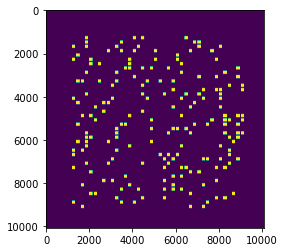

In [461]:
max_coord = int(np.max(dCentroids))
pad = 1000
org_rad = 75
image = np.zeros((max_coord + pad*2, max_coord + pad*2))
dCentroids_scaled = dCentroids+pad

for (c1, c2) in dCentroids_scaled:
    x = int(c2)
    y = int(c1)
    image[x-org_rad:x+org_rad, y-org_rad:y+org_rad] = 255
    
plt.imshow(image)
plt.show()

In [462]:
# extract features from design centroids in match

In [463]:

def extract_features(sigma, centroids, pad=1000, org_rad=75):
    max_coord = int(np.max(centroids))
    
    image = np.zeros((max_coord + pad*2, max_coord + pad*2))
    dCentroids_scaled = centroids+pad

    for (c1, c2) in dCentroids_scaled:
        x = int(c2)
        y = int(c1)
        image[x-org_rad:x+org_rad, y-org_rad:y+org_rad] = 255
    
    im_blur = ndimage.gaussian_filter(cp.array(image), sigma=sigma, mode='constant',cval=0)
    im_blur_norm=im_blur*sigma*cp.sqrt(np.pi)

    plt.imshow(im_blur_norm.get())
    plt.show()

    im_sx = ndimage.sobel(im_blur_norm, axis=1, mode='reflect')
    im_sy = ndimage.sobel(im_blur_norm, axis=0, mode='reflect')
    im_sobel=np.hypot(im_sx, im_sy)
    
    plt.imshow(im_sobel.get())
    plt.show()

    feats = []
   
    for (c1, c2) in dCentroids_scaled:
        x = int(c2)
        y = int(c1)
        density = np.mean(im_blur_norm[x-org_rad: x+org_rad, y-org_rad: y+org_rad])
        if np.isnan(density):
            print(x,y)
        assert(~np.isnan(density))
        grad = np.mean(im_sobel[x-org_rad: x+org_rad, y-org_rad: y+org_rad])
        assert(~np.isnan(grad))
        feats.append([density.get(), grad.get()])
        
    mempool = cp.get_default_memory_pool()
    pinned_mempool = cp.get_default_pinned_memory_pool()

    mempool.free_all_blocks()
    pinned_mempool.free_all_blocks()

    feats = np.array(feats)
    return feats

In [464]:
sigmas = list(range(200,1200, 200))

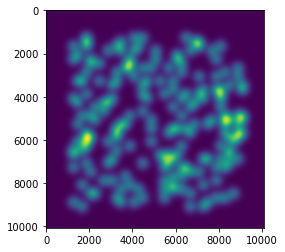

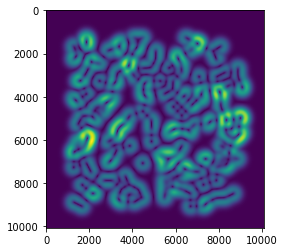

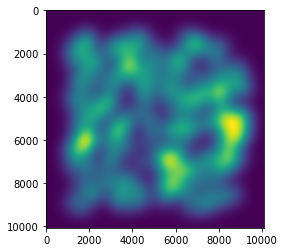

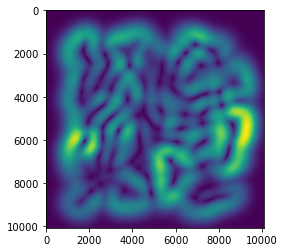

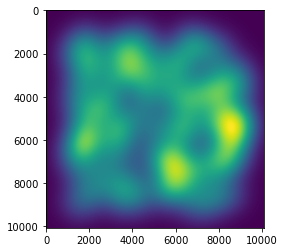

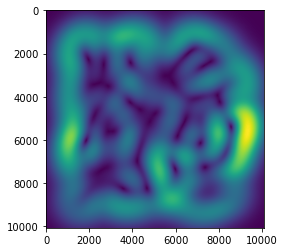

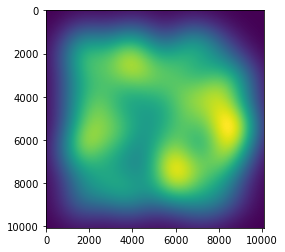

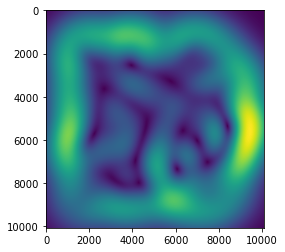

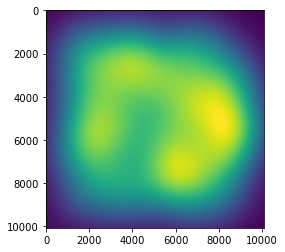

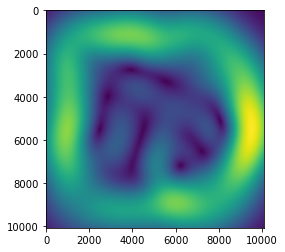

In [465]:
all_feats = []
for sigma in sigmas:
    feats = extract_features(sigma, dCentroids)
    all_feats.append(feats)

In [466]:
columns = ["d200","g200","d400","g400","d600","g600","d800","g800","d1000","g1000"]
sigma_feats = pd.DataFrame(np.hstack(all_feats), columns=columns)

In [467]:
sigma_feats.head()

,d200,g200,d400,g400,d600,g600,d800,g800,d1000,g1000
0,13284.352640,281.312429,11388.435131,131.564856,11965.160953,107.704044,13326.529246,95.876637,14887.589185,91.405101
1,9533.493087,137.110970,12110.429945,126.953663,14342.023785,124.459279,16477.544973,118.204209,18830.633694,111.063935
2,9355.589013,141.426400,10193.051250,124.889516,12249.280298,120.119210,14985.632060,116.398060,17882.554981,110.011635
3,8317.548435,101.794070,9765.648314,147.124780,11557.970566,110.106028,13211.307545,91.798140,15248.193960,88.023941
4,16857.038760,135.243979,13971.410531,88.447729,14492.138003,93.285162,15576.944445,88.721506,16928.149412,88.551507


In [468]:
# get metrics from final centroids in match

In [469]:
yDF = pd.read_csv(os.path.join(metricsDir, final_f))

In [470]:
yDF.head()

,Dipole,Elongation,Aspect_Ratio,Centroid_x,Centroid_y,Diff_of_means,CDX2_1 Marker,CDX2_2 Marker,Minor Axis,Skeleton
0,0.123426,90.0,0.838028,564,4387,0.144631,0.300901,0.358621,82.083104,103.083261
1,0.059660,97.0,1.509615,318,4238,0.139659,0.280364,0.345219,85.538787,105.941125
2,0.045718,45.0,0.792079,1848,4227,0.154180,0.270930,0.378444,65.775409,52.698485
3,0.005221,31.0,0.724138,1513,4207,0.192834,0.319579,0.455929,71.560547,32.485281
4,0.150508,111.0,1.443609,3125,4201,0.099182,0.345949,0.343602,90.886023,126.982756


In [471]:
y_unsorted = yDF.values[:, 3:5]

In [472]:
# matching is fine..whew 
fCentroids.shape, np.unique(fCentroids, axis=0).shape

((192, 2), (192, 2))

In [473]:
# heitor's points are fine..whew x 2
y_unsorted.shape, np.unique(y_unsorted, axis=0).shape

((192, 2), (192, 2))

In [474]:
sort_ixs = []
n = len(fCentroids)
for i in range(n):
    tiled = np.tile(fCentroids[i], (n,1))
    norm = np.linalg.norm(y_unsorted - tiled, axis = 1)
    ix = np.argmin(norm)
    sort_ixs.append(ix)

In [475]:
yDF_sorted = yDF.loc[sort_ixs].reset_index(drop=True)
yDF_sorted

,Dipole,Elongation,Aspect_Ratio,Centroid_x,Centroid_y,Diff_of_means,CDX2_1 Marker,CDX2_2 Marker,Minor Axis,Skeleton
0,0.133947,84.0,0.767606,421,262,0.152228,0.366377,0.414668,70.867909,99.154329
1,0.258325,118.0,0.803109,1623,191,0.072441,0.370967,0.342607,94.886375,141.852814
2,0.122814,108.0,0.735632,1762,200,0.107520,0.384154,0.397153,103.252870,121.911688
3,0.262415,102.0,1.342657,2845,132,0.076675,0.348485,0.330206,120.726639,111.355339
4,0.237762,108.0,1.189394,422,406,0.066268,0.480865,0.401523,100.814879,116.941125
...,...,...,...,...,...,...,...,...,...,...
187,0.045718,45.0,0.792079,1848,4227,0.154180,0.270930,0.378444,65.775409,52.698485
188,0.243359,110.0,0.915789,3646,3974,0.106703,0.353087,0.359624,81.034302,147.936075
189,0.123426,90.0,0.838028,564,4387,0.144631,0.300901,0.358621,82.083104,103.083261
190,0.150508,111.0,1.443609,3125,4201,0.099182,0.345949,0.343602,90.886023,126.982756


In [476]:
# sort_ixs are unique
len(sort_ixs), len(np.unique(sort_ixs))

(192, 192)

In [477]:
# sorted yDF values are unique
len(sort_ixs), len(np.unique(sort_ixs))

(192, 192)

In [478]:
np.all(fCentroids == yDF_sorted.values[:, 3:5])

True

In [479]:
# combine datasets

In [480]:
matched_df = pd.DataFrame(mDF, columns=["dx","dy","fx","fy"])

In [481]:
big_df = pd.concat([matched_df, sigma_feats, yDF_sorted], axis = 1)

In [482]:
big_df.to_csv(os.path.join(saveDir,"big_df"+str(rnd)+".csv"), index = False)

In [483]:
train_df = big_df.iloc[:, 4:15]

In [484]:
train_df.to_csv(os.path.join(saveDir,"train_df"+str(rnd)+".csv"), index = False)

# big_train_df

In [485]:
big_train = []
for i in range(1, 7):
    df = pd.read_csv(os.path.join(saveDir,"train_df"+str(i)+".csv"))
    big_train.append(df)

In [486]:
big_train_df = pd.concat(big_train, axis = 0)

In [487]:
big_train_df.to_csv(os.path.join(saveDir,"big_train_df.csv"), index = False)

In [110]:
big_train_df.head()

,d200,g200,d400,g400,d600,g600,d800,g800,d1000,g1000,Dipole
0,12569.750538,299.909620,15206.124552,190.998335,18516.581353,177.519546,23320.732905,190.635151,28067.155155,192.440417,0.654604
1,21652.258103,407.670314,25964.204453,305.450923,30795.914912,236.286336,35669.057654,209.096572,40262.816687,201.456233,0.246289
2,21974.051582,358.723557,29766.180886,301.621300,33649.694392,237.483838,37427.495746,207.409793,41439.883431,200.194272,0.080416
3,24660.577808,453.983852,33561.981431,318.609253,37090.413894,236.786075,39331.763175,204.794285,42527.737883,199.766463,0.018438
4,23792.642285,310.406549,33234.855791,335.342770,37008.456975,244.534294,39129.724448,208.015262,42343.032966,201.654154,0.000000


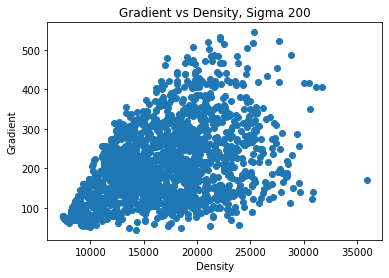

In [111]:
d, g = big_train_df.iloc[:, 0],big_train_df.iloc[:, 1]
plt.scatter(d,g)
plt.title("Gradient vs Density, Sigma 200")
plt.xlabel("Density")
plt.ylabel("Gradient")
plt.show()

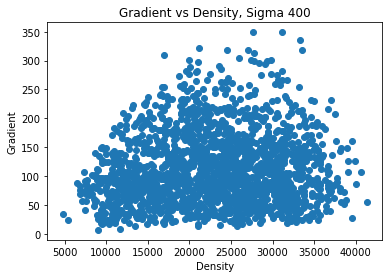

In [341]:
d, g = big_train_df.iloc[:,2],big_train_df.iloc[:, 3]

plt.scatter(d,g)
plt.title("Gradient vs Density, Sigma 400")
plt.xlabel("Density")
plt.ylabel("Gradient")
plt.show()

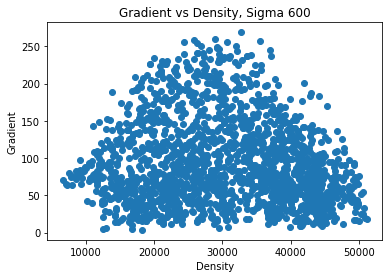

In [342]:
d, g = big_train_df.iloc[:, 4],big_train_df.iloc[:, 5]

plt.scatter(d,g)
plt.title("Gradient vs Density, Sigma 600")
plt.xlabel("Density")
plt.ylabel("Gradient")
plt.show()

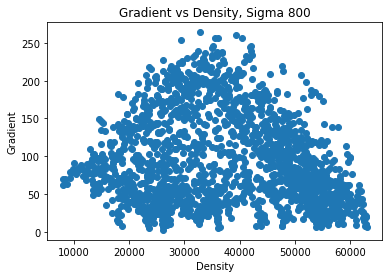

In [343]:
d, g = big_train_df.iloc[:, 6],big_train_df.iloc[:, 7]

plt.scatter(d,g)
plt.title("Gradient vs Density, Sigma 800")
plt.xlabel("Density")
plt.ylabel("Gradient")
plt.show()

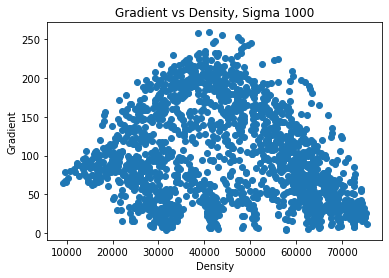

In [344]:
d, g = big_train_df.iloc[:, 8],big_train_df.iloc[:, 9]

plt.scatter(d,g)
plt.title("Gradient vs Density, Sigma 1000")
plt.xlabel("Density")
plt.ylabel("Gradient")
plt.show()